In [1]:
%load_ext autoreload
%autoreload 2
# Configure JAX for 64-bit computing
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
# numpy dependencies
import numpy as np
# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
# jax dependencies
import jax
import jax.numpy as jnp
from jax import random
key = random.PRNGKey(0)
keys = random.split(key, 10)
# cr-sparse dependencies
import cr.sparse as crs
import cr.sparse.la as crla
import cr.sparse.cluster as crcluster
import cr.sparse.cluster.vq
import cr.sparse.cluster.spectral
import cr.sparse.cluster.ssc as ssc
%matplotlib inline

In [139]:
# local dependencies
from data_setup import *

In [4]:
# Load the yale faces dataset
yale = YaleFaces()

In [5]:
yale.num_total_faces, yale.num_subjects

(2414, 38)

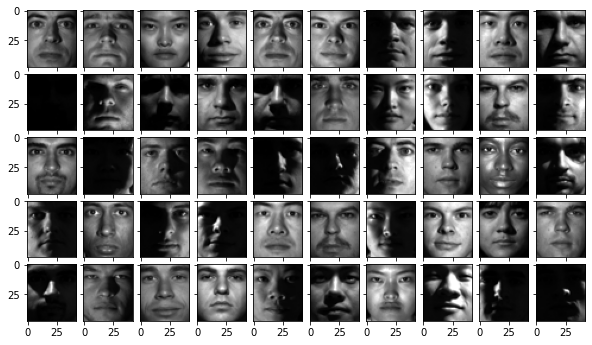

In [6]:
# Let's draw a few random faces
some_faces = yale.random_images(keys[0], 50)
some_faces.shape
fig = plt.figure(figsize=(10, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, some_faces):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)

In [7]:
# all the face images organized in columns of a matrix
X = yale.faces.T
X.shape

(2016, 2414)

In [8]:
# Compute the angles between every pair of points in X in degrees
angles = ssc.angles_between_points(X)
angles.shape

(2414, 2414)

In [9]:
# Minimum and maximum angles between any pairs of points in X
print(crs.off_diagonal_min(angles), crs.off_diagonal_max(angles))

4.170605459045412 89.13620033321158


In [10]:
# Minimum angle for  each point w.r.t. points inside the cluster to which it belongs
inside_mins = ssc.min_angles_inside_cluster(angles, yale.cluster_sizes)

In [11]:
# Minimum angle for  each point w.r.t. points outside its own cluster
outside_mins = ssc.min_angles_outside_cluster(angles, yale.cluster_sizes)

In [12]:
# Difference between the angle of the nearest point within the cluster and nearest point outside the cluster
diff_mins = outside_mins - inside_mins

In [13]:
# The points for which the closest point is outside the same cluster
jnp.sum(diff_mins < 0)

DeviceArray(380, dtype=int64)

In [14]:
# indices of the nearest neighbors inside the cluster for each point
inn = ssc.nearest_neighbors_inside_cluster(angles, yale.cluster_sizes)

In [15]:
# cross-checking for consistency
s = 2000
angles[s, inn[s]], inside_mins[s]

(DeviceArray(45.37109679, dtype=float64),
 DeviceArray(45.37109679, dtype=float64))

In [16]:
# indices of the nearest neighbors outside the cluster for each point
onn = ssc.nearest_neighbors_outside_cluster(angles, yale.cluster_sizes)

In [17]:
# cross checking for consistency
s = 500
angles[s, onn[s]], outside_mins[s]

(DeviceArray(15.95201417, dtype=float64),
 DeviceArray(15.95201417, dtype=float64))

In [19]:
# indices for the sorted neighbors for each point across all points
# each row is the list of neighbors for a particular point
sorted_neighbors = ssc.sorted_neighbors(angles)
sorted_neighbors.shape

(2414, 2413)

In [20]:
# cross checking for consistency
s = 50
sorted_neighbors[s, 0], inn[s], onn[s], inside_mins[s], outside_mins[s]

(DeviceArray(930, dtype=int64),
 DeviceArray(48, dtype=int64),
 DeviceArray(930, dtype=int64),
 DeviceArray(14.49495572, dtype=float64),
 DeviceArray(14.10128301, dtype=float64))

In [21]:
# map the neighbor index lists to corresponding cluster labels
sorted_neighbor_labels = yale.labels[sorted_neighbors]
sorted_neighbor_labels.shape

(2414, 2413)

In [28]:
# For the first image (in first cluster), among the first 20 neighbors, first 8 are from same cluster, the 9-th one is from
# cluster 2, then 3 more from same cluster, then others are from different clusters.
sorted_neighbor_labels[0, :20]

DeviceArray([ 0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  2, 18,  9,
              2, 28,  0, 14, 18], dtype=uint8)

[   1   35    6   10   39    0   37    8 1169 1775    2  916   11  611
 1071  582]


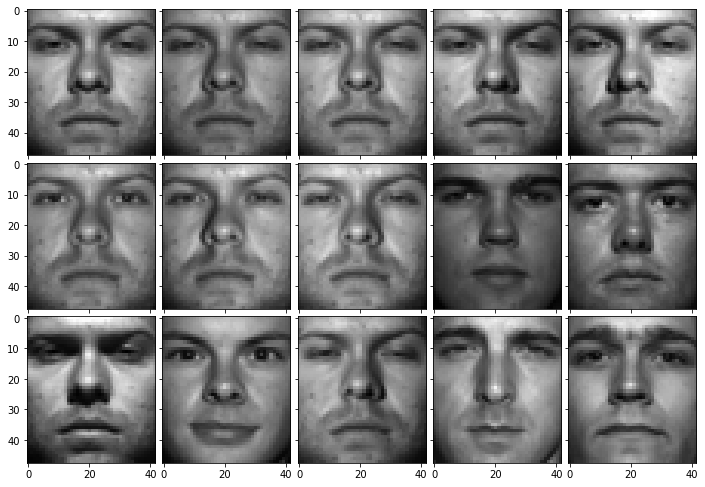

In [34]:
# Let's see the first 15 neighbors of the second picture in cluster 1.
s = 1
indices = sorted_neighbors[s, :15]
indices = jnp.insert(indices, 0, s)
print(indices)
images = yale.select_images(indices)
fig = plt.figure(figsize=(12, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)

In [35]:
# for image no 50, the nearest neighbor is from cluster 14 and second nearest neighbor is from same cluster
sorted_neighbor_labels[50, :20]

DeviceArray([14,  0, 36,  5,  0, 17,  2,  9,  6, 18, 35,  2,  3,  9, 24,
             36, 28,  0, 23,  7], dtype=uint8)

[  50  930   48 2336  370   52 1120  176  626  434 1184 2272  178  242
  624 1568]


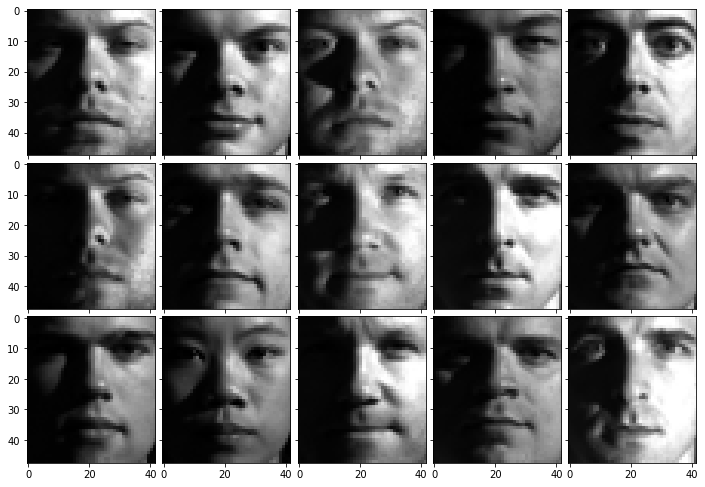

In [36]:
# Let's see the first 15 neighbors of the pic number 50 in cluster 1
s = 50
indices = sorted_neighbors[s, :15]
indices = jnp.insert(indices, 0, s)
print(indices)
images = yale.select_images(indices)
fig = plt.figure(figsize=(12, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)

In [23]:
# Indices for the nearest neighbor inside the same cluster in the neighbor list for each point
inn_positions = ssc.inn_positions(yale.labels, sorted_neighbor_labels)

In [24]:
# for image no 50, the nearest neighbor inside the cluster is at index 1.
inn_positions[50]

DeviceArray(1, dtype=int64)

In [26]:
# Percentage of points whose nearest neighbor is not within the same cluster
jnp.sum(inn_positions > 0) * 100 / yale.num_total_faces

DeviceArray(15.74150787, dtype=float64)

In [41]:
# inn position statistics
unique, counts = jnp.unique(inn_positions, return_counts=True)
print(jnp.asarray((unique, counts)))

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   28   29   30   31
    32   33   38   48]
 [2034  140   60   31   20   30   14    6    8    8    6    9    8    3
     6    5    3    1    1    1    2    2    6    1    1    1    1    2
     1    1    1    1]]


In [48]:
# percentage of points for which the inn position is 0
zero_inn_position_perc = float(counts[0] * 100 / yale.num_total_faces)
print(f'{zero_inn_position_perc=:.2f}')

zero_inn_position_perc=84.26


In [50]:
non_zero_inn_position_perc = 100 - zero_inn_position_perc
print(f'{non_zero_inn_position_perc=:.2f}')

non_zero_inn_position_perc=15.74


In [51]:
# percentage of points for which the inn position is 1
one_inn_position_perc = float(counts[1] * 100 / yale.num_total_faces)
print(f'{one_inn_position_perc=:.2f}')

one_inn_position_perc=5.80


In [52]:
# percentage of points for which the inn position is 2
two_inn_position_perc = float(counts[2] * 100 / yale.num_total_faces)
print(f'{two_inn_position_perc=:.2f}')

two_inn_position_perc=2.49


In [53]:
# percentage of points for which the inn position is 5 or more
five_plus_inn_position_perc = float(jnp.sum(counts[5:]) * 100 / yale.num_total_faces)
print(f'{five_plus_inn_position_perc=:.2f}')

five_plus_inn_position_perc=5.34


[ 366  622   46  864 1116  493  365 1820  557 2332 1564  373  926 2012
  430 2268]


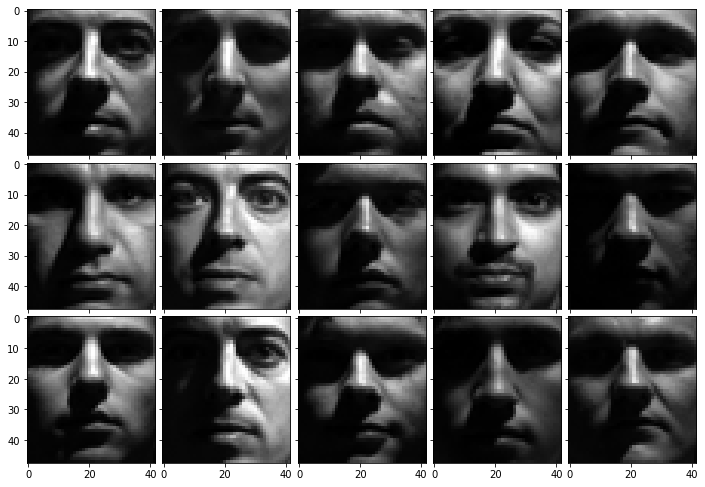

In [56]:
# let's look at the neighbors of a point whose nearest neighbor inside the cluster is at position 5.
s = jnp.argmax(inn_positions == 5)
indices = sorted_neighbors[s, :15]
indices = jnp.insert(indices, 0, s)
print(indices)
images = yale.select_images(indices)
fig = plt.figure(figsize=(12, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)

In [71]:
# Identify the points for which the nearest neighbor is inside the cluster
zero_inn_points = jnp.where(inn_positions == 0)[0]
num_zero_inn = zero_inn_points.shape[0]
num_zero_inn

2034

In [69]:
# zero inn position inside neighbor outside neighbor angle differences
in_out_angle_diffs_zero_inns = diff_mins[zero_inn_points]
in_out_angle_diffs_zero_inns

(2034,)

In [136]:
# percentage of points with angle difference between nearest inside cluster and nearest outside cluster less than 2 degree
float(jnp.sum(in_out_angle_diffs_zero_inns <= 2) * 100 / yale.num_total_faces)

15.285832642916322

In [137]:
# percentage of points with angle difference between nearest inside cluster and nearest outside cluster less than 4 degree
float(jnp.sum(in_out_angle_diffs_zero_inns <= 4) * 100 /  yale.num_total_faces)

31.731565865782933

In [81]:
negative_diff_points = jnp.where(diff_mins < 0)[0]
num_neg_diff_points = negative_diff_points.shape[0]
print(num_neg_diff_points)
print(num_neg_diff_points*100. / yale.num_total_faces)

380
15.741507870753935


In [87]:
# the angle differences where outside cluster neighbor is nearer to inside cluster neighbor
in_out_negative_angle_diffs = -diff_mins[negative_diff_points]
print(jnp.round(in_out_negative_angle_diffs, 1))

[15.6  3.3  2.1  5.1  0.4  5.3  2.8  0.4  1.1  2.8  0.4 14.8  3.7  0.9
  1.3  3.6  0.2  5.9  0.2 14.7  1.   3.7  0.6  0.   5.5  2.2  4.9  2.
  2.8  0.2  0.6  3.9  0.4  0.  11.9  3.1  0.1  0.4  0.4  1.7  6.4  4.2
  0.2  2.   0.   2.5  1.8  2.9  5.6  1.3  3.9  9.1  3.6  0.6  2.8  2.
  4.2  0.3  4.7  0.8 18.7 10.9  0.5  4.2  0.7  0.2  1.1  1.6  7.   1.9
  0.8 18.6  1.4  3.5  1.3  2.7  0.1  1.9  0.3  1.5  7.   1.8  5.2  0.3
  9.4  8.9  1.3  0.6  1.6 15.6  2.   0.6  6.5  0.6  0.6  0.9  2.   7.2
  0.8  2.9  2.2  1.2  5.5  1.2  1.1  0.8  1.   4.1  0.4  0.7  2.5  0.4
  2.5 13.9  0.   5.1  0.   1.2  0.2  2.6  4.7 12.8 12.   0.1  0.   0.8
  1.5  5.   7.5  3.4 15.3  3.5  2.3  1.3  2.   5.5  2.9  0.1  1.5  3.8
  9.1  1.4  1.1  0.3 11.1  4.2  1.3 15.9 18.3  1.2  6.7  1.4  1.7  5.1
  4.4 14.   1.3  7.6  0.9  2.5  0.5  0.3  9.6  5.6  2.8 12.7 15.   4.1
  9.8  1.   0.3  9.   2.2  0.3  0.5  1.6 14.2  1.9  0.   0.4  0.   1.2
  0.7  2.3  2.9  9.2  2.4 13.1  0.8  1.9 21.2  4.8  0.7  0.5  0.3  6.3
  1.2 10

In [90]:
# percentage of points with angle difference between nearest outside cluster and nearest inside cluster less than 2 degree
float(jnp.sum(in_out_negative_angle_diffs <= 2) * 100 / yale.num_total_faces)

6.9179784589892295

In [91]:
# percentage of points with angle difference between nearest outside cluster and nearest inside cluster less than 4 degree
float(jnp.sum(in_out_negative_angle_diffs <= 4) * 100 / yale.num_total_faces)

9.942004971002486

In [92]:
# percentage of points where absolute difference in angle between inside and outside nearest neighbor is less than 4 degree
float(jnp.sum(jnp.abs(diff_mins) <= 4) * 100 / yale.num_total_faces)

41.673570836785416

# Statistics over a pair of subjects

In [155]:
analyze_subject_list(yale, (0,1))

Cluster sizes:  [64 64]
Total images: 128
Minimum angle between any pair of points: 4.17 degrees.
Maximum angle between any pair of points: 83.71 degrees.
Number of points with nearest neighbor outside cluster:  2
Inn position labels, counts, percentages: 
[[  0.    1.    2. ]
 [126.    1.    1. ]
 [ 98.4   0.8   0.8]]
Zero inn position: 98.44 %
Non-zero inn position: 1.56 %


In [154]:
analyze_subject_list(yale, (3,4))

Cluster sizes:  [64 64]
Total images: 128
Minimum angle between any pair of points: 5.15 degrees.
Maximum angle between any pair of points: 83.61 degrees.
Number of points with nearest neighbor outside cluster:  0
Inn position labels, counts, percentages: 
[[  0.]
 [128.]
 [100.]]
Zero inn position: 100.00 %
Non-zero inn position: 0.00 %


In [153]:
analyze_subject_list(yale, (34,35))

Cluster sizes:  [64 64]
Total images: 128
Minimum angle between any pair of points: 5.10 degrees.
Maximum angle between any pair of points: 88.24 degrees.
Number of points with nearest neighbor outside cluster:  8
Inn position labels, counts, percentages: 
[[  0.    1.    2. ]
 [120.    5.    3. ]
 [ 93.8   3.9   2.3]]
Zero inn position: 93.75 %
Non-zero inn position: 6.25 %
